In [1]:
import requests
import spotipy
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pprint import pprint
from statistics import mean
from requests.auth import HTTPBasicAuth
from client import client_id, client_secret

In [2]:
token_url = "https://accounts.spotify.com/api/token"
headers = {'content-type': 'application/x-www-form-urlencoded'}

token_params = {"grant_type" : "client_credentials"}

token_json = requests.post(token_url, params = token_params, headers = headers, auth = (client_id, client_secret)).json()
token = token_json['access_token']

In [3]:
token_headers = {'authorization': f"Bearer {token}"}

US_top50_df = pd.read_csv("Top Country CSV/US_top_50.csv")

artist_count = 0
genres = []
genre_count = []

search_artist_url = "https://api.spotify.com/v1/artists/"

for artist_id in US_top50_df["Artist ID"]:
    artist_url = search_artist_url + artist_id
    
    artist_json = requests.get(artist_url, headers = token_headers).json()
    
    try:
        genres_list = artist_json["genres"]
        
        for genre in genres_list:
            if genre not in genres:
                genres.append(genre)
                genre_count.append(1)

            else:
                genre_count[genres.index(genre)] += 1
                
        artist_count += 1
                
    except (KeyError, IndexError):
        print(f"Artist ID not found | {artist_id}")
        
genre_zip = zip(genres, genre_count)
sorted_genre_zip = sorted(genre_zip, key = lambda count : count[1], reverse = True)

genre = list(zip(*sorted_genre_zip))[0]
genre_count = list(zip(*sorted_genre_zip))[1]

In [4]:
genre_popularity_df = pd.DataFrame({"Genres" : genre, "Genre Counts" : genre_count})
genre_popularity_df["Genre Popularity Percentage"] = (genre_popularity_df["Genre Counts"]/artist_count) * 100
genre_popularity_df.head()

,Genres,Genre Counts,Genre Popularity Percentage
0,pop,31,62.0
1,rap,24,48.0
2,trap music,17,34.0
3,dance pop,14,28.0
4,pop rap,14,28.0


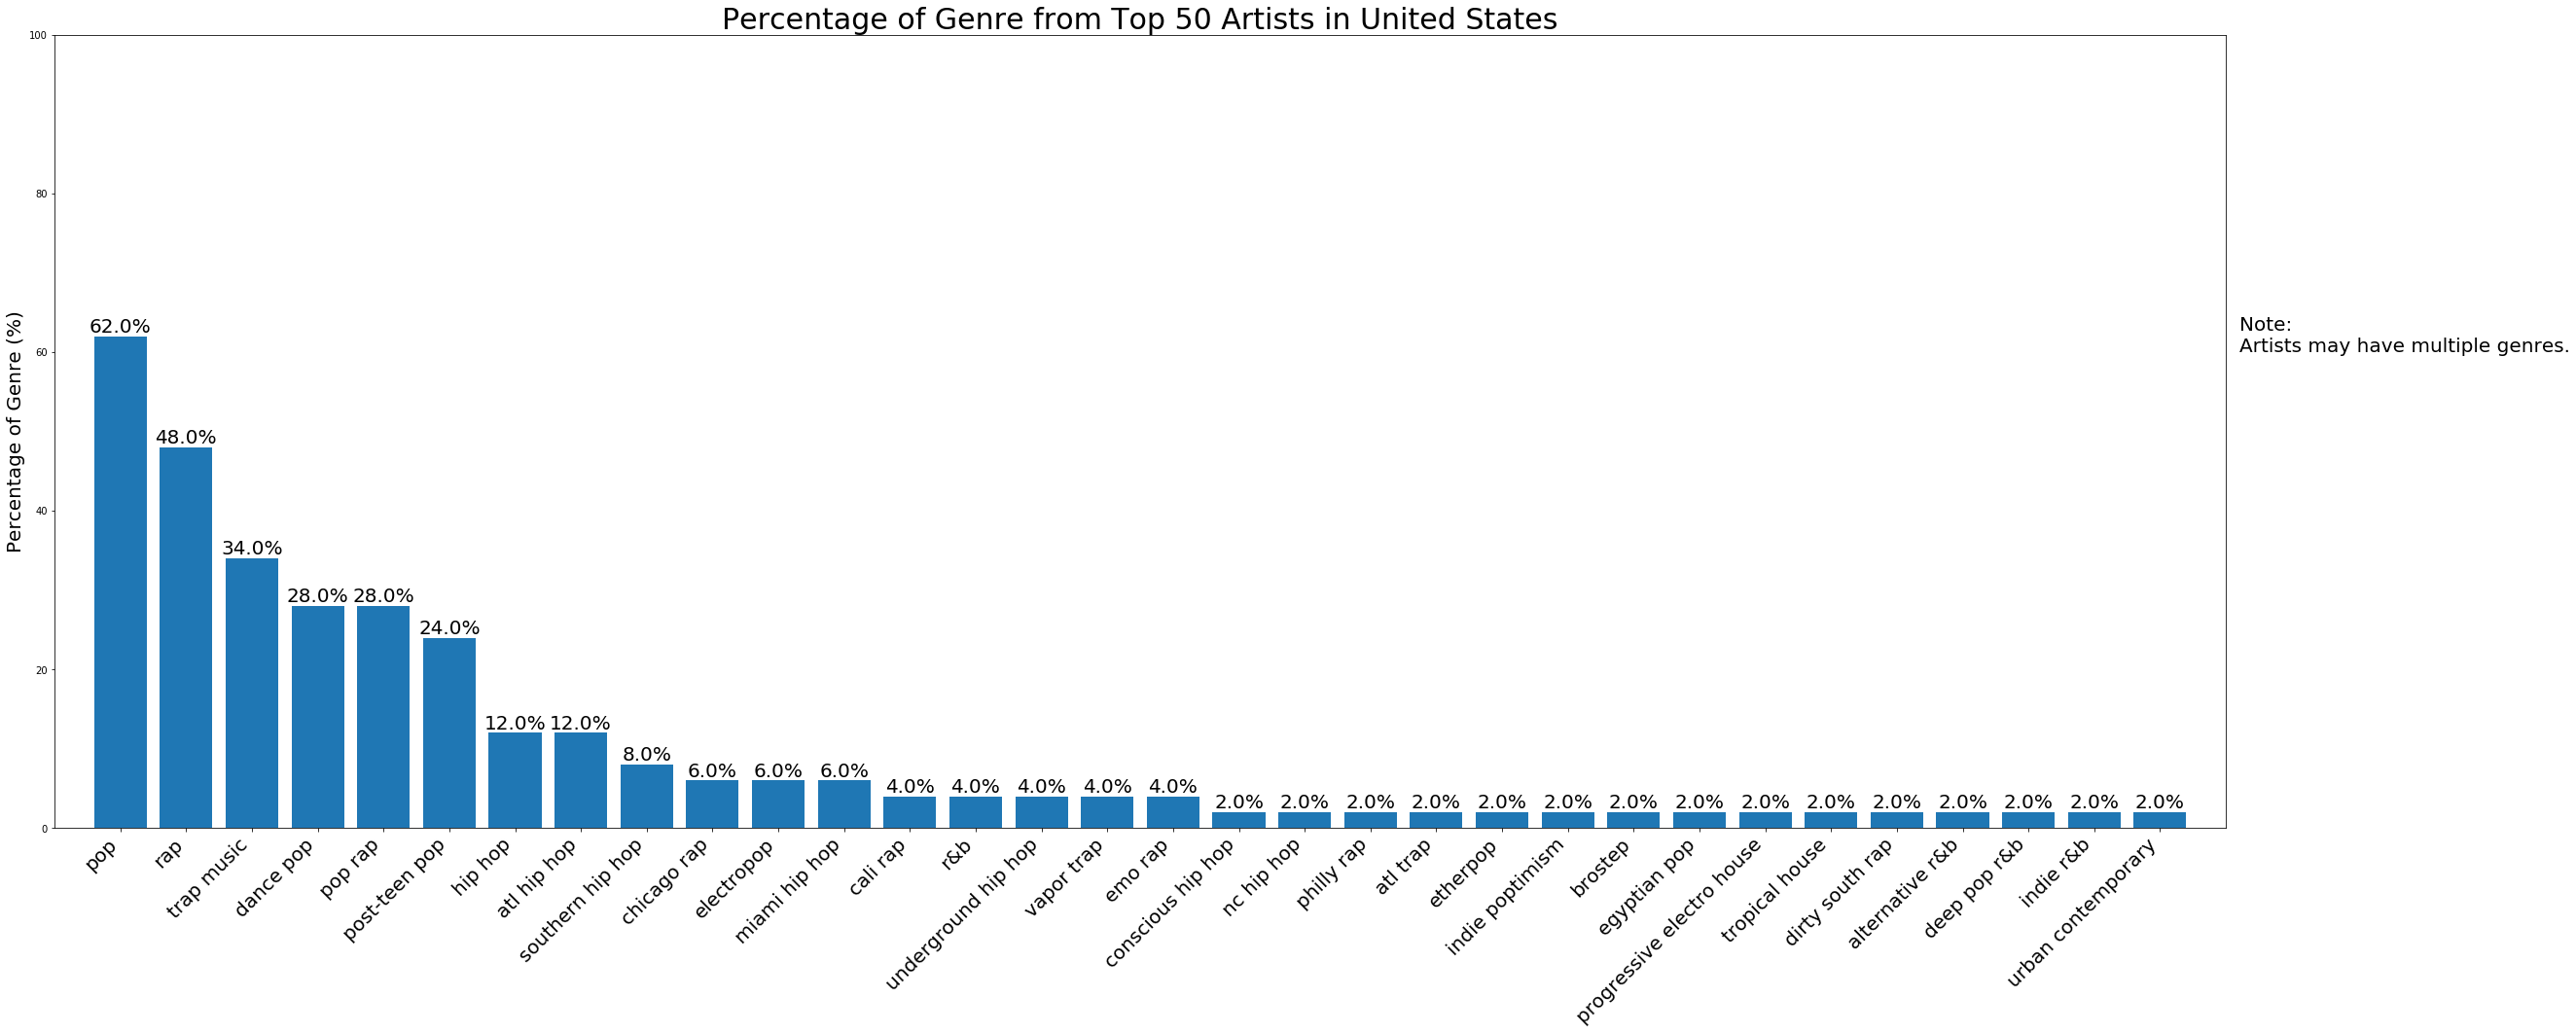

In [5]:
fig, ax = plt.subplots(figsize = (40,15))

x_axis = np.arange(len(genre))
y_axis = genre_popularity_df["Genre Popularity Percentage"]

ax.bar(x_axis, y_axis)
plt.xticks(x_axis, genre_popularity_df["Genres"],Fontsize = 20, rotation = 45, ha = "right")
plt.xlim(min(x_axis) - 1, max(x_axis) + 1)
plt.ylim(0, 100)
plt.ylabel("Percentage of Genre (%)", Fontsize = 20)
plt.title("Percentage of Genre from Top 50 Artists in United States", Fontsize = 30)
plt.text(max(x_axis) + 1.2, 60, "Note:\nArtists may have multiple genres.", Fontsize = 20)

rects = ax.patches

for rect in rects:
    box_width = rect.get_width()
    height = rect.get_height()
    width = rect.get_x() + box_width / 2
    if height > 0:
        ax.text(width, height, f'{round(height,2)}%', Fontsize = 20, ha = 'center', va = 'bottom')
    else:
         ax.text(width, height, f'{round(height,2)}%', Fontsize = 20, ha = 'center', va = 'top')

plt.show()

In [6]:
search_artist_url = "https://api.spotify.com/v1/artists/"

artist_count = 0

pop_count = 0
pop_danceability = []

trap_count = 0
trap_danceability = []

rap_count = 0
rap_danceability = []

for i in range(len(US_top50_df["Artist ID"])):
    artist_url = search_artist_url + US_top50_df["Artist ID"][i]
    
    artist_json = requests.get(artist_url, headers = token_headers).json()
    
    try:
        genre_list = artist_json["genres"]
        
        if "pop" in genre_list:
            pop_count += 1
            pop_danceability.append(US_top50_df["Danceability"][i])
            
        if "trap music" in genre_list:
            trap_count += 1
            trap_danceability.append(US_top50_df["Danceability"][i])
            
        if "rap" in genre_list:
            rap_count += 1
            rap_danceability.append(US_top50_df["Danceability"][i])
                
        artist_count += 1
                
    except (KeyError, IndexError):
        print(f"Artist ID not found | {artist_id}")

In [7]:
stats.ttest_ind(pop_danceability, rap_danceability, equal_var=False)

Ttest_indResult(statistic=-2.1103987304867817, pvalue=0.03959543074453047)

In [8]:
stats.ttest_ind(pop_danceability, trap_danceability, equal_var=False)

Ttest_indResult(statistic=-2.184838266817116, pvalue=0.03502697165229509)

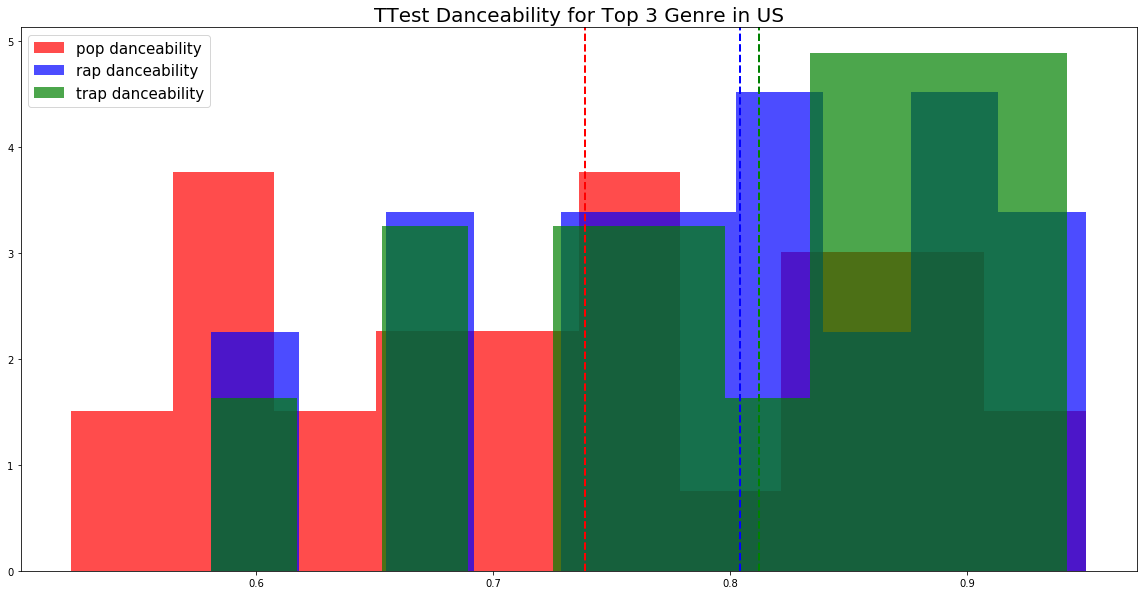

In [9]:
fig, ax = plt.subplots(figsize = (20,10))

ax. hist(pop_danceability, density = True, alpha = 0.7, color = 'r', label = "pop danceability")
ax. hist(rap_danceability, density = True, alpha = 0.7, color = 'b', label = "rap danceability")
ax. hist(trap_danceability, density = True, alpha = 0.7, color = 'g', label = "trap danceability")

ax.axvline(mean(pop_danceability), color='r', linestyle='dashed', linewidth = 2)
ax.axvline(mean(rap_danceability), color='b', linestyle='dashed', linewidth = 2)
ax.axvline(mean(trap_danceability), color = 'g', linestyle='dashed', linewidth = 2)

plt.title("TTest Danceability for Top 3 Genre in US", Fontsize = 20)

plt.legend(loc = "best", prop={'size': 15})

plt.show()

In [10]:
pop_danceability_df = pd.DataFrame({"Danceability" : pop_danceability})
pop_danceability_df.insert(0, "Genre", "pop")

rap_danceability_df = pd.DataFrame({"Danceability" : rap_danceability})
rap_danceability_df.insert(0, "Genre", "rap")

trap_danceability_df = pd.DataFrame({"Danceability" : trap_danceability})
trap_danceability_df.insert(0, "Genre", "trap")

genre_danceability_df = pop_danceability_df.append([rap_danceability_df, trap_danceability_df])

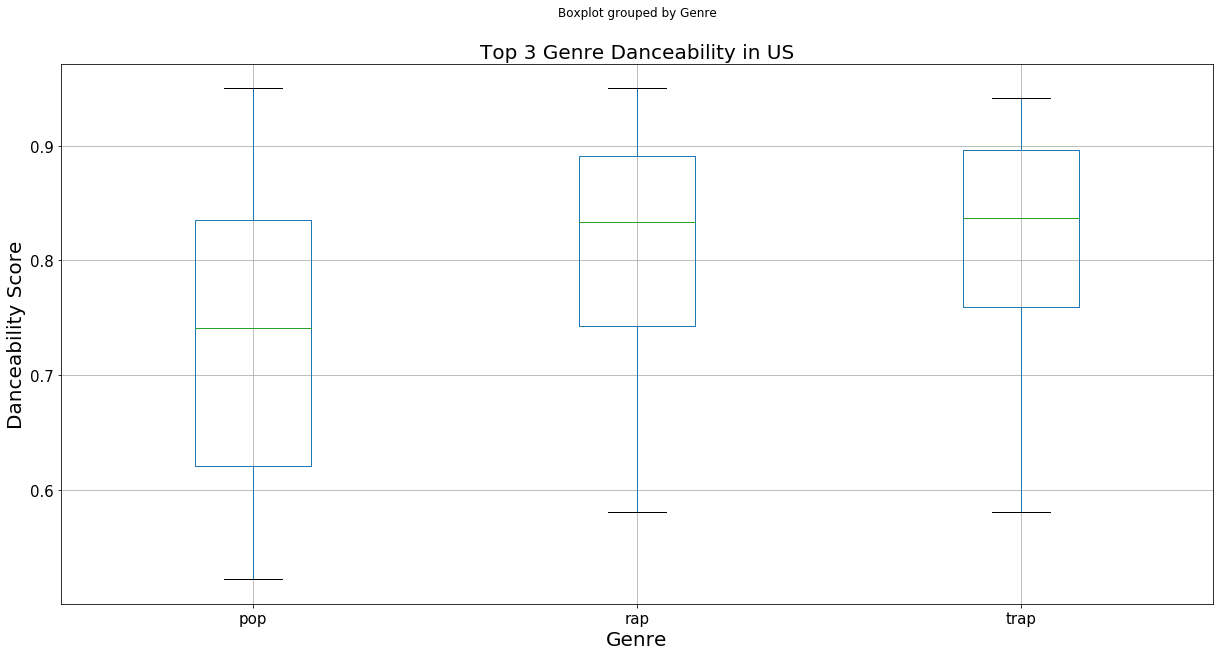

In [13]:
genre_danceability_df.boxplot("Danceability", by = "Genre", figsize = (20,10))
plt.title("Top 3 Genre Danceability in US", Fontsize = 20)
plt.xticks(Fontsize = 15)
plt.yticks(Fontsize = 15)
plt.xlabel("Genre", Fontsize = 20)
plt.ylabel("Danceability Score", Fontsize = 20)

plt.show()

In [12]:
stats.f_oneway(pop_danceability, rap_danceability, trap_danceability)

F_onewayResult(statistic=3.255414194073183, pvalue=0.04456306291749124)